In [1]:
%matplotlib inline

import functools
from itertools import izip
import os
import datetime

from IPython.core.display import HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import pysam
import scipy.stats
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from clipper.src import CLIP_analysis
from gscripts import qtools
from gscripts.encode import encode_helpers
from gscripts.general import dataviz
from gscripts.rnaseq import splicing_map

tqdm.pandas(desc="Progress")
sns.set_style("ticks")
img_dir = "/home/gpratt/Dropbox/Pratt_Gabriel/PapersInProgress/eCLIP_qc/working_figures/fig_2/"

In [2]:
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

matplotlib.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [3]:
input_norm_dir = "/projects/ps-yeolab3/encode/analysis/Eric_Input_Norm/"
split_dir = "/home/gpratt/projects/idr/analysis/idr_v1/"
out_dir = "/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/"
frip_out_dir = "/home/gpratt/projects/encode/analysis/frip_calculations/"

downsample_path = "/home/gpratt/projects/idr/analysis/downsample_v2/"

In [4]:
merged_data = encode_helpers.get_merged_data()

print len(merged_data)
#Filter out anything sequenced after 16/7/18
merged_data = merged_data[merged_data['Submitted Date'] < datetime.date(2016, 7, 18)]
#Filter out anything not_qced
merged_data = merged_data[merged_data.is_qced]
#Filter out any data we are planning on submitting, but haven't yet submitted
merged_data = merged_data[merged_data.annotation != "Submit"]

660


# Merge rmrep Counts

In [5]:
#Get all the counts
counts_list = pd.read_csv("downsample_counts_full_v4.csv", dtype={"RBP_ID": str, "bio_rep": str, "tech_rep": str},
                         index_col=["RBP_ID", "RBP", "bio_rep", "tech_rep", "fraction"])
counts_list = counts_list.xs(1.0, level="fraction").groupby(level=['RBP_ID', "RBP", "bio_rep"]).sum()
counts_list.index.rename(["uID", "RBP", "rep"], inplace=True)
counts_list.index = counts_list.index.droplevel("RBP")

counts_list['rep'] = ["rep1" if rep == 1 else "rep2" for rep in counts_list.index.get_level_values(level="rep")]
counts_list.index = counts_list.index.droplevel("rep")
counts_list = counts_list.set_index("rep", append=True)


In [6]:
merged_data = merged_data.reset_index(['Cell line', 'RBP'])

merged_data = pd.merge(merged_data, counts_list,
        left_index=True, right_index=True, how="left")

merged_data = merged_data.set_index(["RBP", "Cell line"], append=True)
merged_data = merged_data.reorder_levels(['uID','RBP', 'Cell line','rep'])

In [7]:
print "number of datasets without reads merged"
print len(merged_data[merged_data.unique.isnull()])

number of datasets without reads merged
0


# Merge regular counts (non-repmapped counts)

In [8]:
final_qc_frame = pd.read_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/encode_master_qc.csv")
final_qc_frame = final_qc_frame.fillna("")
final_qc_frame['Reads Written Round 2'] = final_qc_frame['Reads Written Round 2'].astype(int)
final_qc_frame = final_qc_frame.set_index(keys=["rbp", "encode_id", "rep", "cell_type", "full_name", "barcode"])
filtered_final_qc_frame = final_qc_frame[[ "Input Reads", "Reads Written", "repetitive_count", "Reads Passing Quality Filter",
                                          "Uniquely Mapped Reads", "Uniquely mapped reads %", 'Number of reads mapped to too many loci',
                                          '% of reads unmapped: too short', '% of reads mapped to too many loci', "Usable Reads",
                                          "Fraction Collapsed", "Fraction Usable", "Num Peaks", "Reads Written Round 2"]]

grouped_final_qc_frame = filtered_final_qc_frame.groupby(level=['rbp', 'encode_id', 'rep', 'cell_type', 'full_name']).sum()
grouped_final_qc_frame["Fraction Collapsed"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Uniquely Mapped Reads'].astype(float)
grouped_final_qc_frame["Fraction Usable"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Input Reads'].astype(float)
grouped_final_qc_frame = grouped_final_qc_frame.dropna()
grouped_final_qc_frame['full_name'] = grouped_final_qc_frame.index.get_level_values(level="full_name")


In [9]:
#Make sure we can join input counts
fn_label_map = pd.read_table("/home/gpratt/projects/encode/scripts/encode_GRCh38_v1.txt", header=None,
              names=['fn', 'species', 'label', 'foo', 'bar', 'baz', 'biz'])
fn_label_map['fn_basename'] = fn_label_map.fn.apply(lambda x: os.path.basename(x.split(";")[0]).split(".")[0])
fn_label_map['label'] = fn_label_map.label.apply(lambda x: "_".join(x.split("_")[:-1]))

#Need to set the full name of the inputs to the actual name of the file, sadly I'm going to do this badly
inputs = grouped_final_qc_frame.xs("INPUT", level="rep")    
inputs = pd.merge(inputs, fn_label_map,
         left_on="full_name", right_on="label")

In [10]:
new_full_name = []
for name, row in grouped_final_qc_frame.iterrows():
    #print name, row
    name = inputs[inputs.label == row.full_name]
    if len(name) == 1:
        new_full_name.append(name.iloc[0].fn_basename)
    elif len(name) == 0:
        new_full_name.append(row.full_name)
    else:
        new_full_name.append(np.nan)
        print "error", row.full_name
grouped_final_qc_frame['full_file_name'] = new_full_name

error LNG8-M_INPUT_A04F05
error LNG8-S_INPUT_C01D08
error LNG12-N_INPUT_A04F05
error LNG10-M_INPUT_A04F05
error LNG10-S_INPUT_C01D08
error LNG11-M_INPUT_A04F05
error LNG11-S_INPUT_C01D08
error LNG9-M_INPUT_A04F05
error LNG9-S_INPUT_C01D08


In [11]:
merged_data['full_name'] = merged_data.CLIP.apply(lambda x: "_".join(os.path.basename(x).split("_")[:-1]))
merged_data = merged_data.reset_index()

merged_data = pd.merge(merged_data, grouped_final_qc_frame, 
               left_on="full_name", right_on="full_name", 
               how="left")

merged_data = merged_data.set_index(['uID', 'RBP', 'Cell line', 'rep'])

# Get Input Reads

In [12]:
input_names = grouped_final_qc_frame.set_index("full_file_name")
merged_data['input_file_name'] = merged_data.INPUT.apply(lambda x: os.path.basename(x).split(".")[0])
merged_data['input_usable'] = merged_data['input_file_name'].apply(lambda x: input_names.ix[x]['Usable Reads'])
merged_data['input_name'] = merged_data['input_file_name'].apply(lambda x: input_names.ix[x]['full_name'])

# Get Erics rmduped input reads

In [13]:
eric_reads = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/scripts/inline_processing/ENCODE_20170429_newannotations_FINAL.readnumbers.csv",
             names=["uID", "rep", "full_name", "same", "input_reads_name", "input_reads", "usable_name", "usable", 
              "unique_genome_nonrep_name", "unique_genome_nonrep"])
eric_reads = eric_reads.drop(["usable_name", "unique_genome_nonrep_name", "input_reads_name", "same"],axis=1)
eric_reads['uid'] = eric_reads.full_name.apply(lambda x: "_".join(x.split("_")[:-1]))
eric_reads = eric_reads.set_index("uid")

merged_data['family_map_input_usable'] = merged_data['input_name'].apply(lambda x: eric_reads.ix[x]['input_reads'])
#Don't forget that family map input usable is different than unique counts by a bit because I collapse more agressaveily than Eric does (stipping strange muiti-mappers)

# Filter by min read number


In [14]:
arbitray_threshold = 1500000

In [15]:
#Data that passes minimum read threshold requierments
print "before removing low read counts", len(merged_data)

#I'm keep
merged_data = merged_data[(merged_data.unique >= arbitray_threshold) | merged_data.submitted]
#Len after filtering for min reads
print "after removing low read counts", len(merged_data)

before removing low read counts 498
after removing low read counts 474


In [16]:
# print "before removing low read counts in input", len(merged_data)
# merged_data = merged_data[merged_data.total_reads_input > 1000000]
# print "after removing low read counts in input", len(merged_data)

In [17]:
make_and_filter_clipper_stringent = functools.partial(encode_helpers.make_and_filter_clipper, l2fc=5, pval=3)
make_and_filter_clipper_very_lineant = functools.partial(encode_helpers.make_and_filter_clipper, l2fc=0, pval=1)
make_and_filter_clipper_lineant = functools.partial(encode_helpers.make_and_filter_clipper, l2fc=2, pval=1.3)
make_and_filter_clipper_moderate = functools.partial(encode_helpers.make_and_filter_clipper, l2fc=3, pval=3)

In [18]:
#There are some missing bam files, and peak files this is an issue
merged_data = merged_data[merged_data['input_norm'].apply(os.path.exists)]
merged_data = merged_data[merged_data['CLIP'].apply(os.path.exists)]

merged_data['filtered_moderate'] = merged_data['input_norm'].progress_apply(make_and_filter_clipper_moderate)

Progress: 100%|██████████| 472/472 [00:17<00:00, 17.78it/s]


In [19]:
#Can't make this a progress_apply statement because something strange is going on with opening and closing of files
merged_data["CLIP_counts"] = merged_data.CLIP.apply(encode_helpers.get_mapped_reads)
merged_data["INPUT_counts"] = merged_data.INPUT.apply(encode_helpers.get_mapped_reads)

# Combine Reproducable Information with reads mapping to repetitive elements

In [20]:
rep_elements = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/scripts/inline_processing/20170505.ALLENCODEinclnotsubmitted.txt.nopipes.txt",
                            header=0, names= ["element", "file","something", "clip_count", "clip_rpr", "input_count", "input_rpr", "fold-enrichment", "information content"])
merged_data['ip_raw_names'] = merged_data.CLIP.apply(lambda x: os.path.basename(x).split(".")[0])
important_reads = merged_data[['ip_raw_names', 'family_map_input_usable', 'unique']]

In [21]:
entropy_to_ignore = set([
    'unique_3utr',
    'unique_5utr',
    'unique_5utr_and_3utr',
    'unique_CDS',
    'unique_antisense_gencode',
    'unique_distintron',
    'unique_intergenic',
    'unique_noncoding_distintron',
    'unique_noncoding_exon',
    'unique_noncoding_proxintron',
    'unique_proxintron',
    'chrM',
    'antisense_chrM',])

entropy_to_use = list(set(rep_elements.element) - entropy_to_ignore)
rep_elements = rep_elements[rep_elements.element.isin(entropy_to_use)]

In [22]:
def get_chisq_value(row):
    "Calculates Chiseq values for all the reptitive elements"
    clip_total = row['unique'] - row.clip_count 
    input_total = row.family_map_input_usable - row.input_count

    g, p, dof, expctd = scipy.stats.chi2_contingency([[row.clip_count, clip_total], [row.input_count, input_total]])
    return p

In [23]:
rep_elements = pd.merge(rep_elements, important_reads, left_on="file", right_on="ip_raw_names")
rep_elements['p_val'] = rep_elements.apply(get_chisq_value, axis=1)
rep_elements['log10_p_val'] = rep_elements['p_val'].apply(lambda x: np.log10(x) * -1)
rep_elements.loc[np.isinf(rep_elements.log10_p_val), "log10_p_val"] = 400

In [24]:
sig_rep_elements = rep_elements[((rep_elements['log10_p_val'] > 3) & (rep_elements['fold-enrichment'] > 3)) | ((rep_elements.clip_rpr > .4) & (rep_elements['fold-enrichment'] > 1))]
rep_element_information = sig_rep_elements.groupby("file").sum()
rep_element_information = rep_element_information.drop(["fold-enrichment", "family_map_input_usable", "unique", "p_val", "log10_p_val"], axis=1)

In [25]:
merged_data = merged_data.reset_index()

#Some RBPs don't have any rep elements enriched, so I'm just saying they have 0 entropy
merged_data = pd.merge(merged_data, rep_element_information, left_on="ip_raw_names", right_index=True, how="left")
merged_data = merged_data.set_index(['uID', 'RBP', 'Cell line', 'rep'])
merged_data = merged_data.fillna(0)

# Calculate entropy

In [26]:
annotated_bedtool_header = ['chrom', 'start', "stop", "name", "score", "strand", "annotation", "gene_id"]
full_header = ["chrom", "start", "stop", "full_name", "ip_reads", "input_reads", "p_val", "chisq", "test_type", 
               "enrichment", "log10_p_val", "log2_fold_change"]

In [27]:
def get_full_from_annotated(fn):
    stripped_fn = ".".join(fn.split(".")[:-3])
    return stripped_fn + ".full.compressed2.bed.full"

def calculate_entropy(row, total_ip_reads, total_input_reads):
    p_ip = float(row.ip_reads) / total_ip_reads
    p_input = float(row.input_reads) / total_input_reads
    
    return p_ip * np.log2(p_ip / p_input)

def get_entropy_from_annotated(fn):
    fn = os.path.basename(fn)
    stripped_fn = ".".join(fn.split(".")[:-3])
    stripped_fn = os.path.join(out_dir, stripped_fn)
    return stripped_fn + ".full.compressed2.bed.full.entropy.bed"

def sum_entropy(filtered_peaks, original_peaks):
    entropy = pd.read_table(get_entropy_from_annotated(original_peaks))
    filtered_peaks = pd.read_table(filtered_peaks, names=annotated_bedtool_header)

    merged_peaks = pd.merge(filtered_peaks, entropy, 
             left_on=['chrom', 'start', 'stop'],
             right_on=['chrom', 'start', 'stop'])

    return merged_peaks.entropy.sum()

def sum_entropy_row(row):
    #Sadly the majority of the time in this operation is opening the files, can't make it faster :(
    return sum_entropy(row.filtered_moderate, row['input_norm'])

In [28]:
for name, row in tqdm(list(merged_data.iterrows())):    
    full_fn = get_full_from_annotated(row['input_norm'])
    out_fn = os.path.join(out_dir, os.path.basename(full_fn) + ".entropy.bed")
    if os.path.exists(out_fn):
        continue

    ip_reads = row['CLIP_counts']
    input_reads = row['INPUT_counts']

    read_counts = pd.read_table(full_fn, names=full_header)
    
    tool = functools.partial(calculate_entropy, total_ip_reads=ip_reads, total_input_reads=input_reads)
    read_counts['entropy'] = read_counts.apply(tool, axis=1)
    read_counts.to_csv(out_fn, sep="\t", index=False, header=True)

100%|██████████| 472/472 [00:00<00:00, 1088.48it/s]


In [29]:
merged_data['entropy'] = merged_data.progress_apply(sum_entropy_row, axis=1)

Progress: 472it [08:25,  2.25s/it]                       


# Create Analysis for General Plotting


In [30]:
def thresholding_plotter(threshold_col, actual_classification, df):
    df['submitted_plot'] = ["Passed" if submitted else "Failed" for submitted in df[actual_classification]]
    df['group'] = 1
    
    num_rows = 1
    num_cols = 1
    with dataviz.Figure(os.path.join(img_dir, "frip_distribution.svg"), figsize=(5 * num_cols, 5*num_rows)) as fig:
        ax = fig.add_subplot(1,1,1)
        sns.swarmplot(x="group", y=threshold_col, hue="submitted_plot", data=df, ax=ax)
        sns.despine(ax=ax)
        
    true_positive_array, false_positive_array, threshold_array, best_threshold = encode_helpers.get_best_f_score(threshold_col, 
                                                                                              true_clasification_col= actual_classification,
                                                                                              df=df)
    
    
    num_rows = 1
    num_cols = 3
    with dataviz.Figure(os.path.join(img_dir, "reproducibility_test_passed_qc_frip.svg"), figsize=(3 * num_cols, 3 * num_rows)) as fig:
        ax = fig.add_subplot(1,3,1)
        ax.plot(false_positive_array, true_positive_array, label="ROC Curve")
        ax.set_ylabel("True Positive Rate")
        ax.set_xlabel("False Positive Rate")
        ax.plot([0,1], [0,1], label="Null Expectation") 
        sns.despine(ax=ax)
        ax.set_title("ROC Curve")
        ax.legend()

        ax = fig.add_subplot(1,3,2)
        ax.plot(threshold_array, true_positive_array)
        ax.set_ylabel("True Positive Rate")
        ax.set_xlabel("Threshold")
        sns.despine(ax=ax)
        ax.set_title("ROC Curve")
        ax.axvline(best_threshold)

        ax = fig.add_subplot(1,3,3)
        ax.plot(threshold_array, false_positive_array)
        ax.set_ylabel("False Positive Rate")
        ax.set_xlabel("Threshold")
        sns.despine(ax=ax)
        ax.set_title("ROC Curve")
        ax.axvline(best_threshold)

    print encode_helpers.confusion_numbers(best_threshold, threshold_col, true_clasification_col= actual_classification, df=df)

# Classifier for just the family mapping submittable stuff
Family mapping stuff effects ~8 datasets out of ~15, I think I'm going to ignore classifying is differently.  Or just write around it.  

In [31]:
family_map_and_negatives = merged_data[~merged_data.peaks_submitable]

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


0.657894736842
0.612
(25.0, 1.0, 25.0, 107.0)


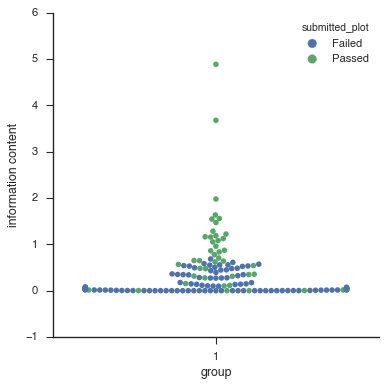

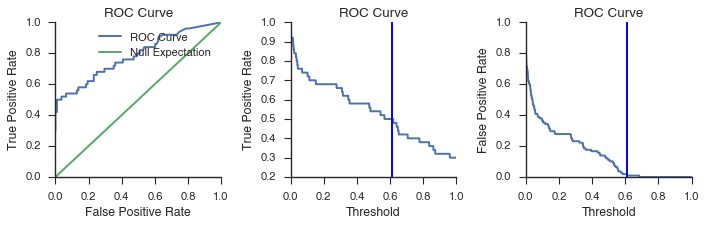

In [32]:
thresholding_plotter('information content', "generally_submittable", family_map_and_negatives)

1. 246  AUH     K562 - failed unknown
1. 358  GNL3    K562 -- failed low info content, due to low reads, ip rpr is under 40% cutoff, would work at 30, rep2 1. doesn't really corospond to rep1, we might have passed something bad...
1. 596  GRSF1   HepG2 -- chrM binder
1. 352  SBDS    K562 -- just misses my rpr cutoff, binds rRNA
1. 450  GPKOW   K562 -- enriched for U6, but not enough, only .3
1. 280  AUH     HepG2 -- chrM stuff
1. 503  TROVE2  HepG2 -- binds too many other places
1. 241  DDX42   K562 -- binds u2, rpr just a bit too low
1. 506  SF3B1   K562 -- information content not high enough
1. 354  NPM1    K562 -- specific to pre-mrna, but again, just not high enuogh
1. 679  RPL23A  HepG2 -- should have passed?
1. 444  LSM11   K562       rep2 -- binds U7, just not highly enough to register

In [43]:
family_map_and_negatives_fn = (family_map_and_negatives[(family_map_and_negatives['information content'] < .612) & family_map_and_negatives.generally_submittable])
family_map_and_negatives_fn[['information content', 'notes']]

CLIP                       information content  \
uID RBP    Cell line rep                         
241 DDX42  K562      rep1             0.069584   
                     rep2             0.113787   
246 AUH    K562      rep1             0.000011   
                     rep2             0.032831   
280 AUH    HepG2     rep1             0.021087   
                     rep2             0.014862   
352 SBDS   K562      rep1             0.040066   
                     rep2             0.015478   
354 NPM1   K562      rep1             0.348901   
                     rep2             0.355152   
358 GNL3   K562      rep1             0.043788   
                     rep2             0.000450   
444 LSM11  K562      rep2             0.481618   
450 GPKOW  K562      rep1             0.036082   
                     rep2             0.018227   
503 TROVE2 HepG2     rep1             0.315248   
                     rep2             0.102513   
506 SF3B1  K562      rep1             0.152487   
                     rep2             0.310007   
539 NOL12  HepG2     rep1             0.277125   
                     rep2             0.566965   
596 GRSF1  HepG2     rep1             0.002802   
                     rep2             0.003521   
679 RPL23A HepG2     rep1             0.474850   
693 SERBP1 K562      rep1             0.542019   

CLIP                                                                   notes  
uID RBP    Cell line rep                                                      
241 DDX42  K562      rep1                                    U2 snRNA, MtDNA  
                     rep2                                    U2 snRNA, MtDNA  
246 AUH    K562      rep1                        MT-Trna binding? also 5sRNA  
                     rep2                        MT-Trna binding? also 5sRNA  
280 AUH    HepG2     rep1                                   MT-TRNA binding?  
                     rep2                                   MT-TRNA binding?  
352 SBDS   K562      rep1  binds ribosome (rRNA very high, % unique mappi...  
                     rep2  binds ribosome (rRNA very high, % unique mappi...  
354 NPM1   K562      rep1  binds ribosome, and tRNAs? rep1 only 500k usab...  
                     rep2  binds ribosome, and tRNAs? rep1 only 500k usab...  
358 GNL3   K562      rep1  binds ribosome, and tRNAs? rep1 only 500k usab...  
                     rep2  binds ribosome, and tRNAs? rep1 only 500k usab...  
444 LSM11  K562      rep2  U7, and a specific repeat very highly chr6    ...  
450 GPKOW  K562      rep1  U6, then a few specific introns but not much else  
                     rep2  U6, then a few specific introns but not much else  
503 TROVE2 HepG2     rep1                   good, yRNA, few CDS/3'UTR also??  
                     rep2                   good, yRNA, few CDS/3'UTR also??  
506 SF3B1  K562      rep1    low usable reads, but only crosslinks to U2/U11  
                     rep2    low usable reads, but only crosslinks to U2/U11  
539 NOL12  HepG2     rep1                   looks like LSU rRNA binding only  
                     rep2                   looks like LSU rRNA binding only  
596 GRSF1  HepG2     rep1  binds crazily to 5’ end of mtDNA chromosome (5...  
                     rep2  binds crazily to 5’ end of mtDNA chromosome (5...  
679 RPL23A HepG2     rep1  looks ok - binds rRNAs well; family mapping 28...  
693 SERBP1 K562      rep1                              >700k RPM to 28S rRNA

# How many datasets can I RECOVER from false negatives in peak level filtering

In [44]:
peak_level_false_negative = merged_data[merged_data.generally_submittable & (merged_data.entropy < .044)]

In [46]:
peak_level_false_negative[(peak_level_false_negative['information content'] > .612) | (peak_level_false_negative.clip_rpr > .40)]

CLIP                                                                     CLIP  \
uID RBP     Cell line rep                                                       
283 HNRNPA1 HepG2     rep1  /projects/ps-yeolab3/encode/analysis/encode_ma...   
                      rep2  /projects/ps-yeolab3/encode/analysis/encode_ma...   
352 SBDS    K562      rep1  /projects/ps-yeolab3/encode/analysis/encode_ma...   
417 POLR2G  K562      rep1  /projects/ps-yeolab3/encode/analysis/encode_ma...   
539 NOL12   HepG2     rep1  /projects/ps-yeolab3/encode/analysis/encode_ma...   

CLIP                          \
uID RBP     Cell line rep      
283 HNRNPA1 HepG2     rep1     
                      rep2     
352 SBDS    K562      rep1     
417 POLR2G  K562      rep1     
539 NOL12   HepG2     rep1     

CLIP                                                                    INPUT  \
uID RBP     Cell line rep                                                       
283 HNRNPA1 HepG2     rep1  /projects/ps-yeolab3/encode/analysis/encode_ma...   
                      rep2  /projects/ps-yeolab3/encode/analysis/encode_ma...   
352 SBDS    K562      rep1  /projects/ps-yeolab3/encode/analysis/encode_ma...   
417 POLR2G  K562      rep1  /projects/ps-yeolab3/encode/analysis/encode_ma...   
539 NOL12   HepG2     rep1  /projects/ps-yeolab3/encode/analysis/encode_ma...   

CLIP                       Submitted Date annotation family family_bound  \
uID RBP     Cell line rep                                                  
283 HNRNPA1 HepG2     rep1     2015-05-06                          FALSE   
                      rep2     2015-05-06                          FALSE   
352 SBDS    K562      rep1     2015-07-26                           TRUE   
417 POLR2G  K562      rep1     2015-11-16                          FALSE   
539 NOL12   HepG2     rep1     2016-01-21                           TRUE   

CLIP                       family_mapping_submitable is_qced note    ...     \
uID RBP     Cell line rep                                            ...      
283 HNRNPA1 HepG2     rep1                     False    True         ...      
                      rep2                     False    True         ...      
352 SBDS    K562      rep1                      True    True         ...      
417 POLR2G  K562      rep1                     False    True         ...      
539 NOL12   HepG2     rep1                      True    True         ...      

CLIP                                                        filtered_moderate  \
uID RBP     Cell line rep                                                       
283 HNRNPA1 HepG2     rep1  /home/gpratt/projects/encode/analysis/peak_rea...   
                      rep2  /home/gpratt/projects/encode/analysis/peak_rea...   
352 SBDS    K562      rep1  /home/gpratt/projects/encode/analysis/peak_rea...   
417 POLR2G  K562      rep1  /home/gpratt/projects/encode/analysis/peak_rea...   
539 NOL12   HepG2     rep1  /home/gpratt/projects/encode/analysis/peak_rea...   

CLIP                       CLIP_counts INPUT_counts    ip_raw_names  \
uID RBP     Cell line rep                                             
283 HNRNPA1 HepG2     rep1    13900913      1968283  283_01_HNRNPA1   
                      rep2     6842287      1968283  283_02_HNRNPA1   
352 SBDS    K562      rep1      690094      1838774     352_01_SBDS   
417 POLR2G  K562      rep1     5530247      2767750   417_01_POLR2G   
539 NOL12   HepG2     rep1     2499259      5415087    539_01_NOL12   

CLIP                       clip_count  clip_rpr  input_count  input_rpr  \
uID RBP     Cell line rep                                                 
283 HNRNPA1 HepG2     rep1  4455434.0  0.271495     390783.0   0.052105   
                      rep2  2176385.0  0.273157     390309.0   0.052042   
352 SBDS    K562      rep1  2335018.0  0.420820    3832722.0   0.393945   
417 POLR2G  K562      rep1  2627189.0  0.219576     696378.0   0.033782   
539 NOL12   HepG2     rep1  8548098.

This is all I need to know right here.  Adding in a term to rescue repetitive element binders doesn't help at all. I can safely ignore a rep-element false negative rescue stragety

In [37]:
threshold = 2
sig_rep_elements = rep_elements[((rep_elements['log10_p_val'] > threshold) & (rep_elements['fold-enrichment'] > threshold)) | ((rep_elements.clip_rpr > .3) & (rep_elements['fold-enrichment'] > 1))]
rep_element_information = sig_rep_elements.groupby("file").sum()
rep_element_information = rep_element_information.drop(["fold-enrichment", "family_map_input_usable", "unique", "p_val", "log10_p_val"], axis=1)

merged_data_rep = merged_data.reset_index()

#Some RBPs don't have any rep elements enriched, so I'm just saying they have 0 entropy
merged_data_rep = pd.merge(merged_data_rep, rep_element_information, left_on="ip_raw_names", right_index=True, how="left")
merged_data_rep = merged_data_rep.set_index(['uID', 'RBP', 'Cell line', 'rep'])
merged_data_rep = merged_data_rep.fillna(0)
family_map_and_negatives_rep = merged_data_rep[~merged_data_rep.peaks_submitable]

In [38]:
#thresholding_plotter('information content', "generally_submittable", family_map_and_negatives_rep)

# Other Expermental Methods

# Fit Rep Elements


In [44]:
from sklearn import linear_model
rep_elements = rep_elements.set_index(['ip_raw_names', 'element'])

In [45]:
import json
import gspread
from oauth2client.client import SignedJwtAssertionCredentials
import statsmodels.api as sm
from sklearn import metrics

json_key = json.load(open("/home/gpratt/ipython_notebook/public clip-588adbc137f3.json"))
scope = ['https://spreadsheets.google.com/feeds']

credentials = SignedJwtAssertionCredentials(json_key['client_email'], json_key['private_key'], scope)
gc = gspread.authorize(credentials)

sht1 = gc.open_by_url("https://docs.google.com/spreadsheets/d/1NMjzbneXf8bGN13K9azoqK2YbMCrjQqfJBKFoCkkrtY/edit#gid=0")
ws = sht1.worksheet("Sheet2")
list_of_lists = ws.get_all_values()
rep_element_annotations = pd.DataFrame(list_of_lists[1:], columns=list_of_lists[0])
rep_element_annotations.interesting = [item == "TRUE" for item in rep_element_annotations.interesting]
rep_element_annotations.checked = [item == "TRUE" for item in rep_element_annotations.checked]

rep_element_annotations = rep_element_annotations[rep_element_annotations.interesting]
#rep_element_annotations = rep_element_annotations[~rep_element_annotations.checked]

In [ ]:
foo = rep_elements['information content'].unstack()
bar = pd.merge(family_map_and_negatives, foo, left_on="ip_raw_names", right_index=True, how="left")


In [ ]:
families_to_use = set(rep_element_annotations.Family.values) - set(['antisense_chrM', 'chrM'])

In [ ]:
len(rep_element_annotations.Family.values)

In [ ]:
len(rep_element_annotations)

In [ ]:
logit = sm.Logit(bar.generally_submittable, bar[list(families_to_use)])

In [ ]:
len(bar) - len(bar[bar.generally_submittable]), len(bar[bar.generally_submittable]) 

In [ ]:
bar['predicted_results'] = result.predict(bar[list(families_to_use)]) < .5 

In [ ]:
metrics.confusion_matrix(bar['family_mapping_submitable'], bar['predicted_results'], labels=[True, False])

In [ ]:
result.summary()

In [ ]:
solver = linear_model.LogisticRegression()


# Decision Tree

https://matterhorn.dce.harvard.edu/engage/player/watch.html?id=8892a8b7-25eb-4bc5-80b6-47b9cf681a05
this class is great
depending on how much you care
this talks about feature importance in a random forest
https://github.com/cs109/2015/blob/master/Lectures/13-BestPractices_Recommendations.pdf


In [ ]:
from sklearn import tree
import pydotplus 
import pyparsing
from IPython.display import Image  
from sklearn.datasets import load_iris
from sklearn import tree


In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(bar[list(families_to_use)], bar.generally_submittable)
#clf.predict(bar.ix['451x4000', "ILF2", "K562", "rep1"][list(families_to_use)])

In [ ]:
with open("iris.dot", 'w') as f:
    dot_data = tree.export_graphviz(clf, out_file=f, 
                                    feature_names=list(families_to_use),  
                                    #class_names=list(set(bar.generally_submittable)),  
                                    filled=True, rounded=True,  
                                    special_characters=True) 


In [ ]:
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)


In [ ]:
with open("iris.dot", 'w') as f:
    dot_data = tree.export_graphviz(clf, out_file=f, 
                             feature_names=iris.feature_names,  
                             class_names=iris.target_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    Image(graph.create_png())  